CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 9 - Assignment
## Basic expectations
- Architecture to C1C2C3C4O (No MaxPooling, but 3 convolutions, where the last one has a stride of 2 instead)
- Use Dilated kernels here instead of MP or strided convolution for extra points
- Total RF must be more than 44
- One of the layers must use Depthwise Separable Convolution
- One of the layers must use Dilated Convolution
- use GAP (compulsory):- add FC after GAP to target #of classes (optional)
- use albumentation library and apply:
  - horizontal flip
  - shiftScaleRotate
  - coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)
- >= 85% accuracy
- As many epochs as you want
- <= 200k params

### Results:
- Epochs: 50
- Parameters: 46,000
- Receptive Field: 247
- Training Batch size: 64
- Testing Batch size: 64
- Training
  - Loss=0.4668
  - Accuracy=83.70%
- Testing
  - Average loss: 0.3972
  - Accuracy: 8655/10000 (86.55%)

### To be provided
- Model code
- Torch Summary
- Albumentations code
- Training log
- README.md link


### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

import utils, model

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [3]:
SEED = 1

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

In [4]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root="../data/cifar10", train=True, download=True, transform=None
    ):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [5]:
# horizontal flip
# shiftScaleRotate
# coarseDropout (max_holes = 1, max_height=16px, max_width=16, min_holes = 1, min_height=16px, min_width=16px, fill_value=(mean of your dataset), mask_fill_value = None)

ds_mean = (0.491, 0.482, 0.447)
ds_std = (0.247, 0.243, 0.262)

train_transforms = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,
                rotate_limit=45, interpolation=1,
                border_mode=4, p=0.2
                ),
                A.CoarseDropout(
                    max_holes=1,
                    max_height=16,
                    max_width=16,
                    min_holes=1,
                    min_height=16,
                    min_width=16,
                    fill_value=ds_mean,
                    mask_fill_value = None,
                    p=0.1,
                ),
                A.RandomBrightnessContrast(p=0.2),
                A.ToGray(p=0.1),
                A.Normalize(
                    mean=ds_mean, std=ds_std
                ),
                ToTensorV2(),
            ]
        )

# Test data transformations
test_transforms = A.Compose([
                A.Normalize(
                    mean=ds_mean, std=ds_std
                ),
                ToTensorV2(),
    ])

### [4. Getting the CIFAR10 train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with *50000* records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [6]:
train = Cifar10Dataset(root="./data", train=True, download=True, transform=train_transforms)
test = Cifar10Dataset(root="./data", train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 76945479.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [7]:
train_batch_size = 64
test_batch_size = 128

In [8]:
kwargs = {'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

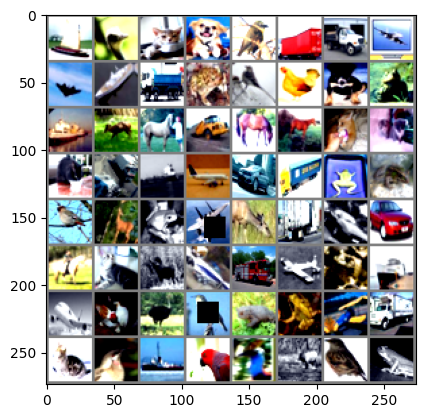

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog 


In [9]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(train_batch_size)))

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [10]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
dropout_value = 0.05
mymodel = model.S9(dropout_value).to(device)
summary(mymodel, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
       BatchNorm2d-2            [-1, 8, 32, 32]              16
              ReLU-3            [-1, 8, 32, 32]               0
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           2,304
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
          Dropout-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [12]:
optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, threshold_mode='rel', verbose=True)
criterion = F.nll_loss
num_epochs = 100

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = utils.train(mymodel, device, train_loader, optimizer, criterion)
  test_acc, test_loss = utils.test(mymodel, device, test_loader, criterion)
  scheduler.step(test_loss)
  print("LR Rate:", optimizer.param_groups[0]['lr'], "\n")
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=2.0720 Batch_id=781 Accuracy=27.35: 100%|██████████| 782/782 [00:33<00:00, 23.16it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.9094, Accuracy: 13676/50000 (27.35%)


Test set: Average loss: 1.6873, Accuracy: 3751/10000 (37.51%)
LR Rate: 0.01 

Epoch 2


Train: Loss=0.8974 Batch_id=781 Accuracy=42.37: 100%|██████████| 782/782 [00:32<00:00, 24.00it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.5641, Accuracy: 21187/50000 (42.37%)


Test set: Average loss: 1.3687, Accuracy: 5005/10000 (50.05%)
LR Rate: 0.01 

Epoch 3


Train: Loss=1.7517 Batch_id=781 Accuracy=49.96: 100%|██████████| 782/782 [00:33<00:00, 23.62it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.3762, Accuracy: 24979/50000 (49.96%)
Test set: Average loss: 1.2241, Accuracy: 5619/10000 (56.19%)
LR Rate: 0.01 

Epoch 4


Train: Loss=1.1118 Batch_id=781 Accuracy=55.07: 100%|██████████| 782/782 [00:33<00:00, 23.18it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.2467, Accuracy: 27536/50000 (55.07%)


Test set: Average loss: 1.1282, Accuracy: 5892/10000 (58.92%)
LR Rate: 0.01 

Epoch 5


Train: Loss=1.2955 Batch_id=781 Accuracy=59.50: 100%|██████████| 782/782 [00:33<00:00, 23.48it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.1411, Accuracy: 29750/50000 (59.50%)


Test set: Average loss: 0.9682, Accuracy: 6578/10000 (65.78%)
LR Rate: 0.01 

Epoch 6


Train: Loss=1.1585 Batch_id=781 Accuracy=62.39: 100%|██████████| 782/782 [00:32<00:00, 23.71it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.0627, Accuracy: 31194/50000 (62.39%)


Test set: Average loss: 0.9330, Accuracy: 6740/10000 (67.40%)
LR Rate: 0.01 

Epoch 7


Train: Loss=0.9331 Batch_id=781 Accuracy=64.54: 100%|██████████| 782/782 [00:33<00:00, 23.43it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.0051, Accuracy: 32271/50000 (64.54%)


Test set: Average loss: 0.8353, Accuracy: 7064/10000 (70.64%)
LR Rate: 0.01 

Epoch 8


Train: Loss=1.1209 Batch_id=781 Accuracy=66.07: 100%|██████████| 782/782 [00:33<00:00, 23.38it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9685, Accuracy: 33035/50000 (66.07%)


Test set: Average loss: 0.9161, Accuracy: 6812/10000 (68.12%)
LR Rate: 0.01 

Epoch 9


Train: Loss=0.5651 Batch_id=781 Accuracy=67.46: 100%|██████████| 782/782 [00:33<00:00, 23.35it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9207, Accuracy: 33732/50000 (67.46%)


Test set: Average loss: 0.7736, Accuracy: 7352/10000 (73.52%)
LR Rate: 0.01 

Epoch 10


Train: Loss=0.5505 Batch_id=781 Accuracy=68.66: 100%|██████████| 782/782 [00:33<00:00, 23.23it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8945, Accuracy: 34331/50000 (68.66%)


Test set: Average loss: 0.7153, Accuracy: 7478/10000 (74.78%)
LR Rate: 0.01 

Epoch 11


Train: Loss=0.9201 Batch_id=781 Accuracy=69.87: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8622, Accuracy: 34937/50000 (69.87%)


Test set: Average loss: 0.6964, Accuracy: 7614/10000 (76.14%)
LR Rate: 0.01 

Epoch 12


Train: Loss=0.9237 Batch_id=781 Accuracy=70.48: 100%|██████████| 782/782 [00:33<00:00, 23.54it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8431, Accuracy: 35241/50000 (70.48%)


Test set: Average loss: 0.6809, Accuracy: 7650/10000 (76.50%)
LR Rate: 0.01 

Epoch 13


Train: Loss=1.1515 Batch_id=781 Accuracy=71.52: 100%|██████████| 782/782 [00:33<00:00, 23.14it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8147, Accuracy: 35761/50000 (71.52%)


Test set: Average loss: 0.6490, Accuracy: 7779/10000 (77.79%)
LR Rate: 0.01 

Epoch 14


Train: Loss=1.0212 Batch_id=781 Accuracy=71.87: 100%|██████████| 782/782 [00:33<00:00, 23.39it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8037, Accuracy: 35937/50000 (71.87%)


Test set: Average loss: 0.6776, Accuracy: 7687/10000 (76.87%)
LR Rate: 0.01 

Epoch 15


Train: Loss=1.4599 Batch_id=781 Accuracy=72.52: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7867, Accuracy: 36262/50000 (72.52%)


Test set: Average loss: 0.6266, Accuracy: 7853/10000 (78.53%)
LR Rate: 0.01 

Epoch 16


Train: Loss=0.3932 Batch_id=781 Accuracy=73.24: 100%|██████████| 782/782 [00:33<00:00, 23.43it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7669, Accuracy: 36620/50000 (73.24%)
Test set: Average loss: 0.6023, Accuracy: 7954/10000 (79.54%)
LR Rate: 0.01 

Epoch 17


Train: Loss=0.4505 Batch_id=781 Accuracy=73.96: 100%|██████████| 782/782 [00:33<00:00, 23.49it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7461, Accuracy: 36981/50000 (73.96%)
Test set: Average loss: 0.6391, Accuracy: 7845/10000 (78.45%)
LR Rate: 0.01 

Epoch 18


Train: Loss=0.3785 Batch_id=781 Accuracy=74.58: 100%|██████████| 782/782 [00:33<00:00, 23.45it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7323, Accuracy: 37288/50000 (74.58%)
Test set: Average loss: 0.6248, Accuracy: 7890/10000 (78.90%)
LR Rate: 0.01 

Epoch 19


Train: Loss=0.6850 Batch_id=781 Accuracy=74.63: 100%|██████████| 782/782 [00:33<00:00, 23.17it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7273, Accuracy: 37315/50000 (74.63%)


Test set: Average loss: 0.5839, Accuracy: 8011/10000 (80.11%)
LR Rate: 0.01 

Epoch 20


Train: Loss=0.6520 Batch_id=781 Accuracy=75.02: 100%|██████████| 782/782 [00:32<00:00, 23.75it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7196, Accuracy: 37512/50000 (75.02%)


Test set: Average loss: 0.5546, Accuracy: 8109/10000 (81.09%)
LR Rate: 0.01 

Epoch 21


Train: Loss=1.0632 Batch_id=781 Accuracy=75.52: 100%|██████████| 782/782 [00:33<00:00, 23.60it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7070, Accuracy: 37758/50000 (75.52%)


Test set: Average loss: 0.5746, Accuracy: 8028/10000 (80.28%)
LR Rate: 0.01 

Epoch 22


Train: Loss=0.8858 Batch_id=781 Accuracy=75.92: 100%|██████████| 782/782 [00:34<00:00, 22.89it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.6957, Accuracy: 37959/50000 (75.92%)


Test set: Average loss: 0.5709, Accuracy: 8074/10000 (80.74%)
LR Rate: 0.01 

Epoch 23


Train: Loss=0.6188 Batch_id=781 Accuracy=76.34: 100%|██████████| 782/782 [00:33<00:00, 23.08it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.6773, Accuracy: 38172/50000 (76.34%)


Test set: Average loss: 0.5566, Accuracy: 8070/10000 (80.70%)
LR Rate: 0.001 

Epoch 24


Train: Loss=0.5680 Batch_id=781 Accuracy=78.55: 100%|██████████| 782/782 [00:33<00:00, 23.20it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.6161, Accuracy: 39277/50000 (78.55%)


Test set: Average loss: 0.4832, Accuracy: 8338/10000 (83.38%)
LR Rate: 0.001 

Epoch 25


Train: Loss=0.4632 Batch_id=781 Accuracy=79.37: 100%|██████████| 782/782 [00:33<00:00, 23.14it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5939, Accuracy: 39685/50000 (79.37%)
Test set: Average loss: 0.4763, Accuracy: 8364/10000 (83.64%)
LR Rate: 0.001 

Epoch 26


Train: Loss=0.5683 Batch_id=781 Accuracy=79.71: 100%|██████████| 782/782 [00:33<00:00, 23.25it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5855, Accuracy: 39855/50000 (79.71%)


Test set: Average loss: 0.4738, Accuracy: 8383/10000 (83.83%)
LR Rate: 0.001 

Epoch 27


Train: Loss=0.4735 Batch_id=781 Accuracy=79.76: 100%|██████████| 782/782 [00:33<00:00, 23.08it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5798, Accuracy: 39878/50000 (79.76%)


Test set: Average loss: 0.4681, Accuracy: 8421/10000 (84.21%)
LR Rate: 0.001 

Epoch 28


Train: Loss=1.2255 Batch_id=781 Accuracy=80.00: 100%|██████████| 782/782 [00:34<00:00, 22.70it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5758, Accuracy: 40001/50000 (80.00%)


Test set: Average loss: 0.4764, Accuracy: 8378/10000 (83.78%)
LR Rate: 0.001 

Epoch 29


Train: Loss=0.5375 Batch_id=781 Accuracy=80.10: 100%|██████████| 782/782 [00:33<00:00, 23.48it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5730, Accuracy: 40048/50000 (80.10%)


Test set: Average loss: 0.4662, Accuracy: 8416/10000 (84.16%)
LR Rate: 0.001 

Epoch 30


Train: Loss=0.6784 Batch_id=781 Accuracy=80.18: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5713, Accuracy: 40091/50000 (80.18%)
Test set: Average loss: 0.4656, Accuracy: 8412/10000 (84.12%)
LR Rate: 0.001 

Epoch 31


Train: Loss=0.6026 Batch_id=781 Accuracy=80.48: 100%|██████████| 782/782 [00:33<00:00, 23.23it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5617, Accuracy: 40240/50000 (80.48%)


Test set: Average loss: 0.4653, Accuracy: 8407/10000 (84.07%)
LR Rate: 0.001 

Epoch 32


Train: Loss=0.5113 Batch_id=781 Accuracy=80.17: 100%|██████████| 782/782 [00:33<00:00, 23.39it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5667, Accuracy: 40086/50000 (80.17%)


Test set: Average loss: 0.4692, Accuracy: 8401/10000 (84.01%)
LR Rate: 0.001 

Epoch 33


Train: Loss=0.4093 Batch_id=781 Accuracy=80.51: 100%|██████████| 782/782 [00:33<00:00, 23.53it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5614, Accuracy: 40254/50000 (80.51%)
Test set: Average loss: 0.4654, Accuracy: 8425/10000 (84.25%)
LR Rate: 0.001 

Epoch 34


Train: Loss=0.2123 Batch_id=781 Accuracy=80.56: 100%|██████████| 782/782 [00:33<00:00, 23.24it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5622, Accuracy: 40279/50000 (80.56%)


Test set: Average loss: 0.4604, Accuracy: 8434/10000 (84.34%)
LR Rate: 0.001 

Epoch 35


Train: Loss=0.5550 Batch_id=781 Accuracy=80.71: 100%|██████████| 782/782 [00:33<00:00, 23.55it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5556, Accuracy: 40354/50000 (80.71%)


Test set: Average loss: 0.4616, Accuracy: 8407/10000 (84.07%)
LR Rate: 0.001 

Epoch 36


Train: Loss=0.4516 Batch_id=781 Accuracy=80.68: 100%|██████████| 782/782 [00:33<00:00, 23.43it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5557, Accuracy: 40342/50000 (80.68%)


Test set: Average loss: 0.4557, Accuracy: 8456/10000 (84.56%)
LR Rate: 0.001 

Epoch 37


Train: Loss=1.1275 Batch_id=781 Accuracy=80.74: 100%|██████████| 782/782 [00:33<00:00, 23.13it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5511, Accuracy: 40371/50000 (80.74%)


Test set: Average loss: 0.4606, Accuracy: 8449/10000 (84.49%)
LR Rate: 0.001 

Epoch 38


Train: Loss=0.7048 Batch_id=781 Accuracy=80.61: 100%|██████████| 782/782 [00:33<00:00, 23.46it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5597, Accuracy: 40306/50000 (80.61%)


Test set: Average loss: 0.4521, Accuracy: 8454/10000 (84.54%)
LR Rate: 0.001 

Epoch 39


Train: Loss=0.4594 Batch_id=781 Accuracy=80.89: 100%|██████████| 782/782 [00:33<00:00, 23.64it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5494, Accuracy: 40444/50000 (80.89%)
Test set: Average loss: 0.4524, Accuracy: 8462/10000 (84.62%)
LR Rate: 0.001 

Epoch 40


Train: Loss=0.4148 Batch_id=781 Accuracy=80.86: 100%|██████████| 782/782 [00:33<00:00, 23.09it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5531, Accuracy: 40429/50000 (80.86%)
Test set: Average loss: 0.4539, Accuracy: 8444/10000 (84.44%)
LR Rate: 0.001 

Epoch 41


Train: Loss=0.5498 Batch_id=781 Accuracy=80.59: 100%|██████████| 782/782 [00:33<00:00, 23.39it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5559, Accuracy: 40294/50000 (80.59%)


Test set: Average loss: 0.4550, Accuracy: 8453/10000 (84.53%)
LR Rate: 0.0001 

Epoch 42


Train: Loss=0.6176 Batch_id=781 Accuracy=81.16: 100%|██████████| 782/782 [00:33<00:00, 23.48it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5409, Accuracy: 40580/50000 (81.16%)


Test set: Average loss: 0.4505, Accuracy: 8470/10000 (84.70%)
LR Rate: 0.0001 

Epoch 43


Train: Loss=0.8111 Batch_id=781 Accuracy=81.16: 100%|██████████| 782/782 [00:33<00:00, 23.49it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5446, Accuracy: 40581/50000 (81.16%)
Test set: Average loss: 0.4476, Accuracy: 8488/10000 (84.88%)
LR Rate: 0.0001 

Epoch 44


Train: Loss=0.8361 Batch_id=781 Accuracy=81.20: 100%|██████████| 782/782 [00:33<00:00, 23.36it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5359, Accuracy: 40601/50000 (81.20%)


Test set: Average loss: 0.4465, Accuracy: 8485/10000 (84.85%)
LR Rate: 0.0001 

Epoch 45


Train: Loss=1.0158 Batch_id=781 Accuracy=80.99: 100%|██████████| 782/782 [00:33<00:00, 23.33it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5446, Accuracy: 40495/50000 (80.99%)


Test set: Average loss: 0.4451, Accuracy: 8497/10000 (84.97%)
LR Rate: 0.0001 

Epoch 46


Train: Loss=0.5902 Batch_id=781 Accuracy=81.33: 100%|██████████| 782/782 [00:33<00:00, 23.17it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5367, Accuracy: 40665/50000 (81.33%)


Test set: Average loss: 0.4429, Accuracy: 8504/10000 (85.04%)
LR Rate: 0.0001 

Epoch 47


Train: Loss=0.7596 Batch_id=781 Accuracy=81.25: 100%|██████████| 782/782 [00:33<00:00, 23.62it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5354, Accuracy: 40623/50000 (81.25%)
Test set: Average loss: 0.4450, Accuracy: 8467/10000 (84.67%)
LR Rate: 0.0001 

Epoch 48


Train: Loss=0.2011 Batch_id=781 Accuracy=81.45: 100%|██████████| 782/782 [00:36<00:00, 21.23it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5339, Accuracy: 40724/50000 (81.45%)
Test set: Average loss: 0.4437, Accuracy: 8506/10000 (85.06%)
LR Rate: 0.0001 

Epoch 49


Train: Loss=0.8762 Batch_id=781 Accuracy=81.55: 100%|██████████| 782/782 [00:33<00:00, 23.30it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5303, Accuracy: 40774/50000 (81.55%)
Test set: Average loss: 0.4483, Accuracy: 8481/10000 (84.81%)
LR Rate: 1e-05 

Epoch 50


Train: Loss=0.3096 Batch_id=781 Accuracy=81.48: 100%|██████████| 782/782 [00:33<00:00, 23.24it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5330, Accuracy: 40740/50000 (81.48%)
Test set: Average loss: 0.4447, Accuracy: 8491/10000 (84.91%)
LR Rate: 1e-05 

Epoch 51


Train: Loss=0.3012 Batch_id=781 Accuracy=81.40: 100%|██████████| 782/782 [00:33<00:00, 23.16it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5321, Accuracy: 40699/50000 (81.40%)
Test set: Average loss: 0.4436, Accuracy: 8502/10000 (85.02%)
LR Rate: 1e-05 

Epoch 52


Train: Loss=0.6673 Batch_id=781 Accuracy=81.42: 100%|██████████| 782/782 [00:33<00:00, 23.21it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5353, Accuracy: 40711/50000 (81.42%)


Test set: Average loss: 0.4428, Accuracy: 8503/10000 (85.03%)
LR Rate: 1e-05 

Epoch 53


Train: Loss=0.7767 Batch_id=781 Accuracy=81.44: 100%|██████████| 782/782 [00:33<00:00, 23.17it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5354, Accuracy: 40718/50000 (81.44%)


Test set: Average loss: 0.4426, Accuracy: 8502/10000 (85.02%)
LR Rate: 1e-05 

Epoch 54


Train: Loss=0.4692 Batch_id=781 Accuracy=81.38: 100%|██████████| 782/782 [00:33<00:00, 23.60it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5329, Accuracy: 40690/50000 (81.38%)


Test set: Average loss: 0.4426, Accuracy: 8511/10000 (85.11%)
LR Rate: 1e-05 

Epoch 55


Train: Loss=0.8569 Batch_id=781 Accuracy=81.41: 100%|██████████| 782/782 [00:33<00:00, 23.19it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5343, Accuracy: 40703/50000 (81.41%)


Test set: Average loss: 0.4429, Accuracy: 8492/10000 (84.92%)
LR Rate: 1e-05 

Epoch 56


Train: Loss=1.0023 Batch_id=781 Accuracy=81.53: 100%|██████████| 782/782 [00:34<00:00, 22.98it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5310, Accuracy: 40766/50000 (81.53%)


Test set: Average loss: 0.4444, Accuracy: 8506/10000 (85.06%)
LR Rate: 1.0000000000000002e-06 

Epoch 57


Train: Loss=0.6043 Batch_id=781 Accuracy=81.53: 100%|██████████| 782/782 [00:33<00:00, 23.51it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.5321, Accuracy: 40763/50000 (81.53%)


Test set: Average loss: 0.4453, Accuracy: 8485/10000 (84.85%)
LR Rate: 1.0000000000000002e-06 

Epoch 58


Train: Loss=0.5108 Batch_id=87 Accuracy=81.20:  11%|█▏        | 88/782 [00:03<00:30, 22.48it/s]


KeyboardInterrupt: 

CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

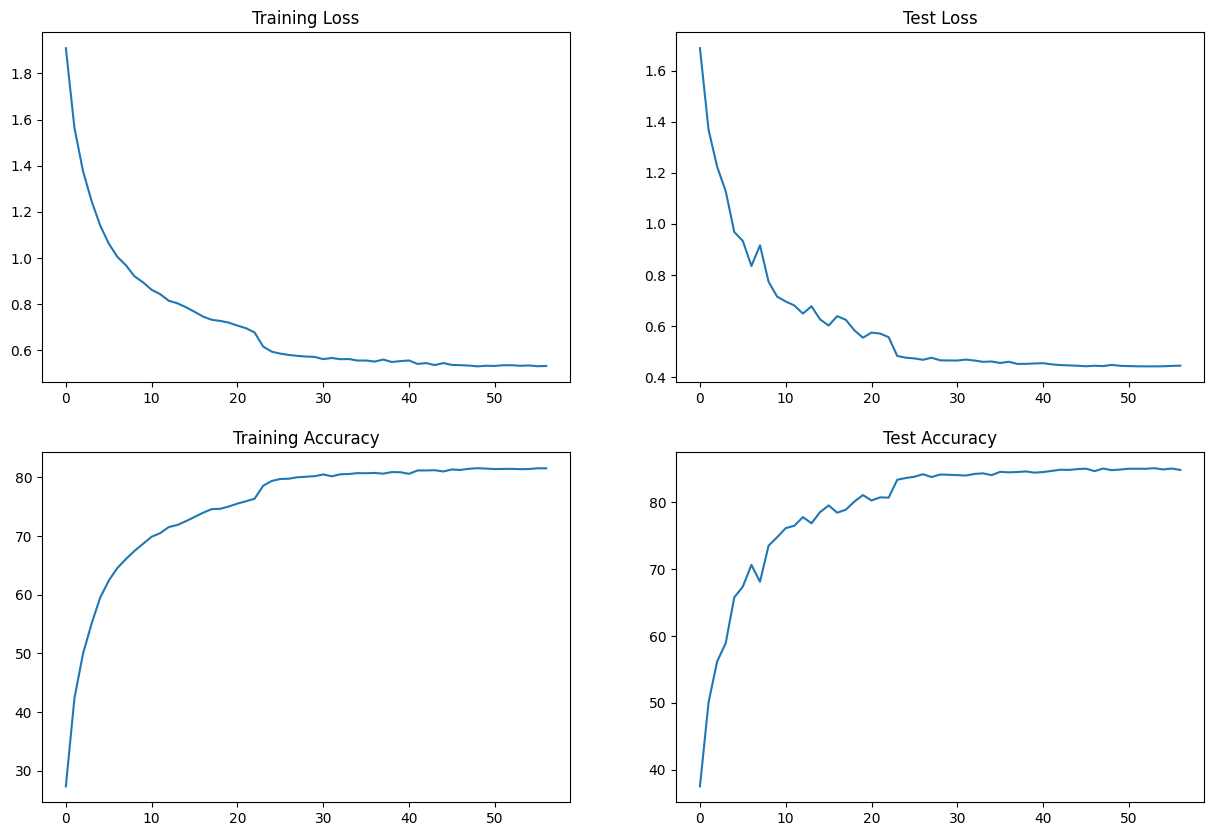

In [13]:
utils.drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

In [14]:
reqData = 10
images, nonMatchingLabels, incorrectPreds = utils.incorrectOutcomes(mymodel, device, test_loader, reqData)

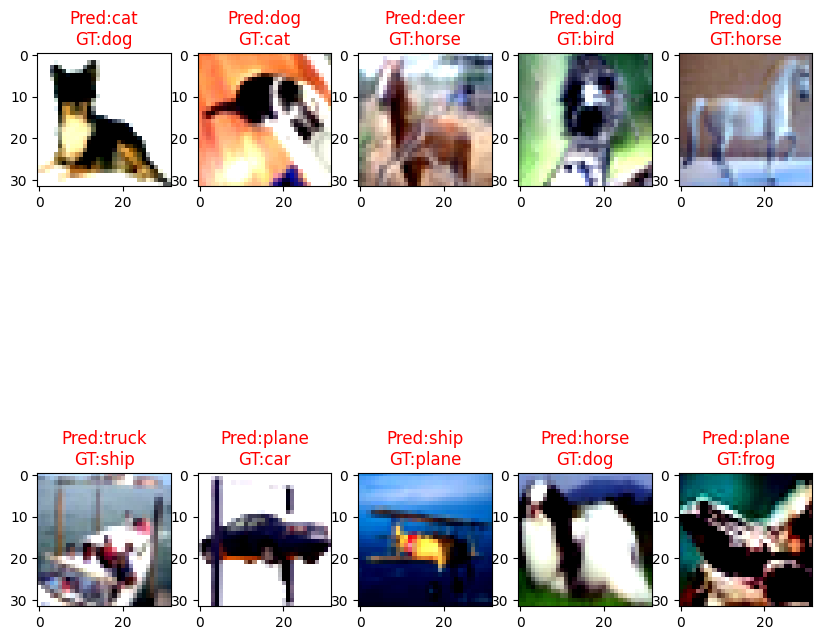

In [15]:
plt.figure(figsize=(10,10))
plt.tight_layout()

right = 0
mistake = 0

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

for i in range(reqData):
    image = images[i]
    pred = classes[incorrectPreds[i]]
    gt = classes[nonMatchingLabels[i]]

    plt.subplot(2,int(reqData/2),i+1)
    plt.imshow(imshow(image))
    plt.axis('on')

    # ret = model.predict(data, batch_size=1)
    #print(ret)

    plt.title("Pred:" + pred + "\nGT:" + gt, color='#ff0000', fontdict={'fontsize': 12})

plt.show()